### Import all packages

In [1]:
import numpy as np
import random as rm
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from scipy.stats import bernoulli, binom, norm
from scipy import integrate
import time

### Basic functions

In [2]:
def f_pi(x, mu, sigma, alpha):
    val = 0
    for i in range(len(mu)):
        val += alpha[i]*norm.pdf(x, mu[i], sigma[i])
    return val
    
def f_eta_unnormalized(x, mu, sigma, alpha, p):
    return f_pi(x, mu, sigma, alpha)**p

def compute_c(mu, sigma, alpha, p):
    def f_eta_unnormalized_temp(x):
        return f_eta_unnormalized(x, mu, sigma, alpha, p)
    c = integrate.quad(f_eta_unnormalized_temp, -np.inf, np.inf)[0]
    return c

# c = compute_c(mu, sigma, alpha, p)
    
def f_eta(x, mu, sigma, alpha, p, c):
    return f_eta_unnormalized(x, mu, sigma, alpha, p)/c

def g(x, mu, sigma, alpha, p, c):
    return(f_pi(x, mu, sigma, alpha)/f_eta(x, mu, sigma, alpha, p, c))

### P kernel and K kernel

In [3]:
def p_kernel(y0, prop_sig_y, n, mu, sigma, alpha, p):
        count = 0
        Yn = y0
        estimator = np.array([y0])
        while count < n:
            y = np.random.normal(Yn, prop_sig_y)
            u = np.random.uniform(0,1)
            a = min(f_eta_unnormalized(y, mu, sigma, alpha, p)/f_eta_unnormalized(Yn, mu, sigma, alpha, p), 1)
            if u <= a:
                estimator = np.append(estimator, y)
                Yn = y
                count += 1
        return estimator

In [4]:
def k_kernel_nsteps(z0, prop_sig_z, n, mu, sigma, alpha):
        count = 0
        Zn = z0
        estimator = np.array([z0])
        while count < n:
            z = np.random.normal(Zn, prop_sig_z)
            u = np.random.uniform(0,1)
            a = min(f_pi(z, mu, sigma, alpha)/f_pi(Zn, mu, sigma, alpha), 1)
            if u <= a:
                estimator = np.append(estimator, z)
                Zn = z
                count += 1
        return estimator

In [5]:
def k_kernel(Xn, prop_sig_x, mu, sigma, alpha):
    Xnew = k_kernel_nsteps(Xn, prop_sig_x, 1, mu, sigma, alpha)[-1]
    return(Xnew)

### Update Y function

In [6]:
def sum_g(sum_old, yn, mu, sigma, alpha, p, c):
    return sum_old + sum(g(yn, mu, sigma, alpha, p, c))

def prob_list(y, sum_old, prob_list_old, mu, sigma, alpha, p, c):
        a = sum_old/sum_g(sum_old, y, mu, sigma, alpha, p, c)
        prob_list = prob_list_old*a
        prob_list = np.append(prob_list, g(y, mu, sigma, alpha, p, c)/sum_g(sum_old, y, mu, sigma, alpha, p, c))
        return prob_list

### Simulate function

In [7]:
def est_error(x_list, mu, sigma, alpha, m):
    
    x_min = min(x_list)
    x_max = max(x_list)
    interval = x_max - x_min
    d_interval = interval/m
    error = 0
    
    for i in range(m):
        count = 0
        
        for j in x_list:
            if (x_min <= j) & (j<= (x_min+d_interval)):
                count += 1
                
        real = count/len(x_list)
        mid_point = (2*x_min + d_interval)/2
        val = f_pi(mid_point, mu, sigma, alpha)
        x_min = x_min + d_interval
        error += abs(real-val)
    
    return error

In [8]:
def simulate(mu, sigma, alpha, p, n, y0_list, prop_sig_x, prop_sig_y, x0_list, eps, N, m):
    
    c = compute_c(mu, sigma, alpha, p)
    
    X_matrix = np.empty((0,n),int)
    Y_matrix = np.empty((0,n),int)
    errors = []
    
    for i in range(N):
        sum_gs = g(y0_list[i], mu, sigma, alpha, p, c)
        X_list = [x0_list[i]]
        Y_list = p_kernel(y0_list[i], prop_sig_y, n, mu, sigma, alpha, p)
        prob_list_Ys = np.array([1])
        
        for k in range(1, n):
            prob_list_Ys = prob_list(Y_list[k], sum_gs, prob_list_Ys, mu, sigma, alpha, p, c)
            sum_gs = sum_g(sum_gs, Y_list[k], mu, sigma, alpha, p, c)
            j = bernoulli(eps).rvs(1)
            
            if j == 0:
                X_list.append(k_kernel(X_list[k-1], prop_sig_x, mu, sigma, alpha)) 
            else:
                X_list.append(np.random.choice(Y_list[:k+1], p = prob_list_Ys))
                                    
        X_matrix = np.append(X_matrix, [X_list], axis=0)
        #x0_list[i] = X_matrix[i][-1]
    
    for i in range(1,int(n/40)):
        # print(X_matrix[:,:int(i*10)])
        error = est_error(X_matrix[:,:int(i*40)].flatten(), mu, sigma, alpha, m)
        errors.append(error)
    
    X_list = X_matrix.flatten()
        
    return X_list, errors

In [9]:
#simulate(mu, sigma, alpha, p, n, y0, prop_sig_x, prop_sig_y, x0, epsilon, N, m)

### Test Example

In [10]:
epsilon = 0.01
y0 = [15, -5, 12, 1, -2]
x0 = [10, 13, -4, -2, 3]
n = 2000
prop_sig_x = 2
prop_sig_y = 2
mu = np.array([0, 17.5])
sigma = np.array([1,4])
alpha = np.array([0.3, 0.7])
N = len(x0)
p = 0.4
m = int(n/10)

x_out = simulate(mu, sigma, alpha, p, n, y0, prop_sig_x, prop_sig_y, x0, epsilon, N, m)[0]

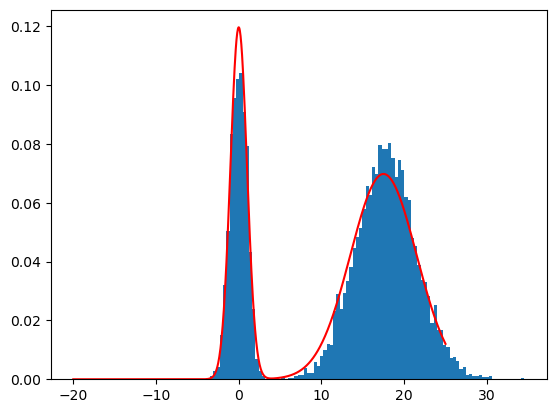

In [11]:
f_pi_plot = lambda z: f_pi(z, mu, sigma, alpha)
plt.hist(x_out, density = True, bins = 100)
t = np.linspace(-20,25,1000)
vals = f_pi_plot(t)

plt.plot(t,vals, 'r')
plt.show()

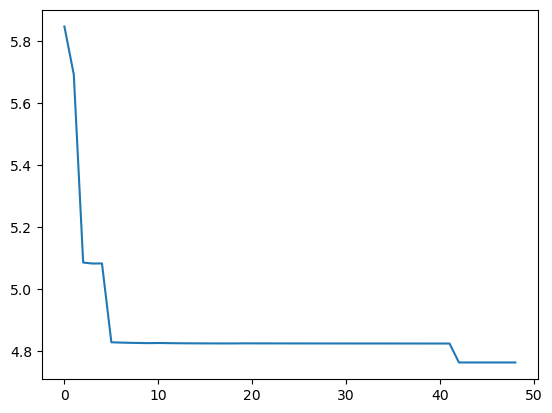

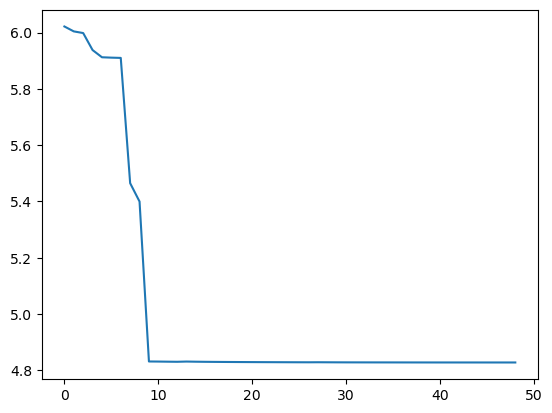

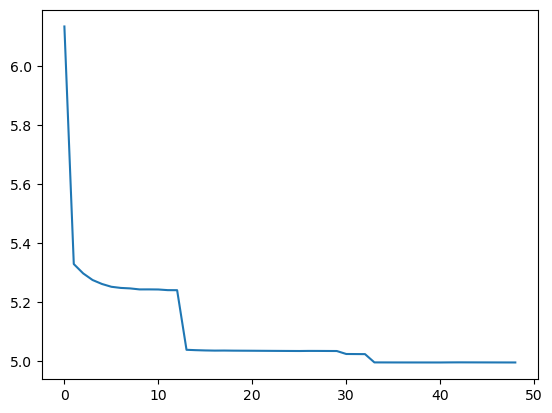

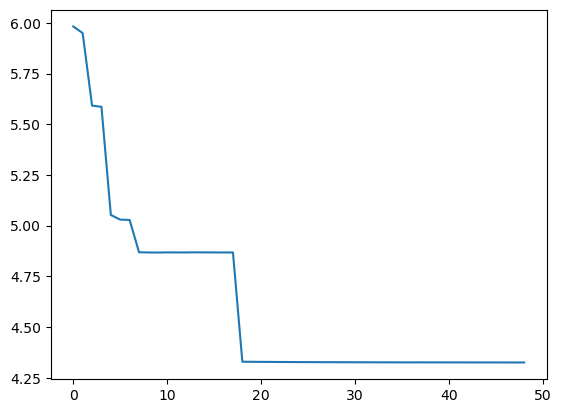

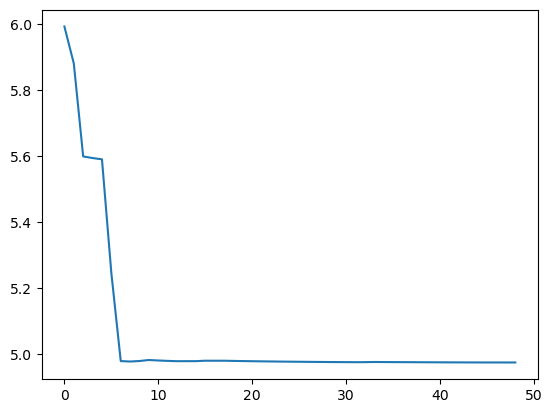

In [12]:
# single case plot
for i in range (5):
    error_out = simulate(mu, sigma, alpha, p, n, y0, prop_sig_x, prop_sig_y, x0, epsilon, N, m)[1]
    plt.plot(error_out)
    plt.show()

### Plot for mean error

In [13]:
import pandas as pd

errors = []
for i in range(5):
    errors.append(simulate(mu, sigma, alpha, p, n, y0, prop_sig_x, prop_sig_y, x0, epsilon, N, m)[1])

errors = pd.DataFrame(errors)
mean_error = errors.mean(axis = 0)

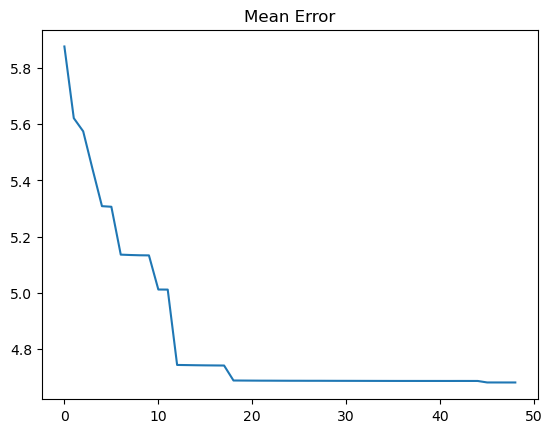

In [14]:
plt.plot(mean_error)
plt.title('Mean Error')
plt.show()

### Explore the initial position

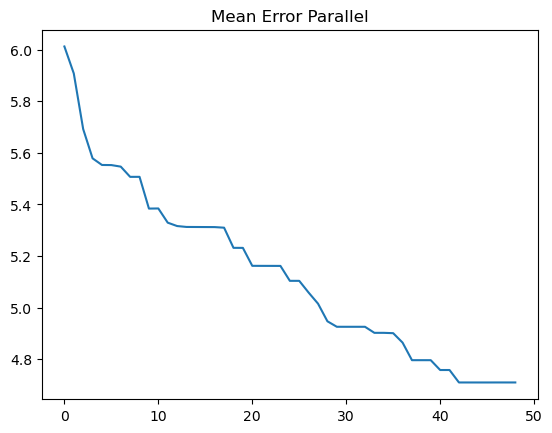

In [15]:
x0 = [0,0,0,17.5,17.5]
y0 = [0,0,0,17.5,17.5]

import pandas as pd

errors = []
for i in range(5):
    errors.append(simulate(mu, sigma, alpha, p, n, y0, prop_sig_x, prop_sig_y, x0, epsilon, N, m)[1])

errors = pd.DataFrame(errors)
mean_error = errors.mean(axis = 0)

plt.plot(mean_error)
plt.title('Mean Error Parallel')
plt.show()

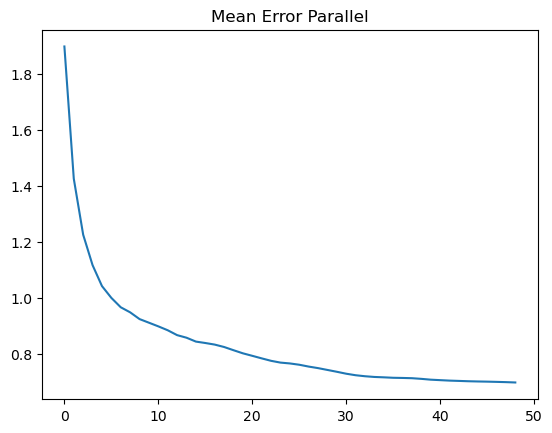

In [16]:
x0 = [-20, -50, 50, 70, -15]
y0 = [-20, -50, 50, 70, -15]
import pandas as pd

errors = []
for i in range(5):
    errors.append(simulate(mu, sigma, alpha, p, n, y0, prop_sig_x, prop_sig_y, x0, epsilon, N, m)[1])

errors = pd.DataFrame(errors)
mean_error = errors.mean(axis = 0)

plt.plot(mean_error)
plt.title('Mean Error Parallel')
plt.show()

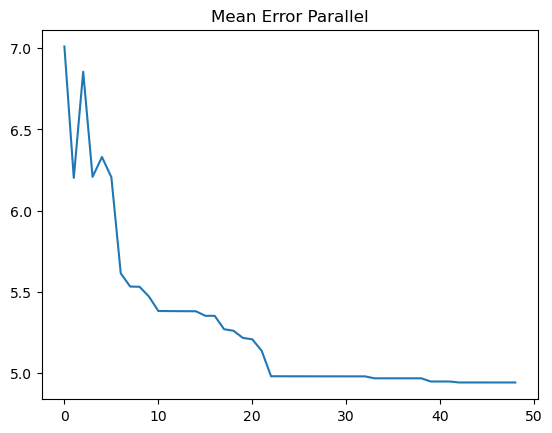

In [17]:
x0 = [0,0,0,0,0]
y0 = [0,0,0,0,0]

import pandas as pd

errors = []
for i in range(5):
    errors.append(simulate(mu, sigma, alpha, p, n, y0, prop_sig_x, prop_sig_y, x0, epsilon, N, m)[1])

errors = pd.DataFrame(errors)
mean_error = errors.mean(axis = 0)

plt.plot(mean_error)
plt.title('Mean Error Parallel')
plt.show()

### Calculate the error (Test)

In [18]:
def est_error(x_list, mu, sigma, alpha, n):
    
    x_min = min(x_list)
    x_max = max(x_list)
    interval = x_max - x_min
    d_interval = interval/n
    error = 0
    
    for i in range(n):
        count = 0
        
        for j in x_list:
            if (x_min <= j) & (j<= (x_min+d_interval)):
                count += 1
                
        real = count/len(x_list)
        mid_point = (2*x_min + d_interval)/2
        val = f_pi(mid_point, mu, sigma, alpha)
        x_min = x_min + d_interval
        error += abs(real-val)
    
    return error

In [19]:
est_error(x_out.flatten(), mu, sigma, alpha, 100)

1.5561264528227703

In [20]:
x_errors = []

for i in range(20):
    result = simulate(mu, sigma, alpha, p, n, y0, prop_sig_x, prop_sig_y, x0, epsilon, N)
    error = est_error(result.flatten(), mu, sigma, alpha, 100)
    x_errors.append(error)
    
error = mean(x_errors)
error

TypeError: simulate() missing 1 required positional argument: 'm'